
**Resutls of conversations with LLMs using this as a starting point:** <br>

A python module to deal with edgelists of business events.
We have a function to recursive search / breadth first search our sql database for the edges.

We need a function to apply rules to that recursive search /  breadth first search based on the node types and the business events.

Primary datastructure is the edgelist with columns = [ 'node1_id','node2_id','node1_type','node2_type','business_event_id','business_event_type','edge_timestamp']

When we query our edgelist table with a breadth first search this is the data structure we get. 

We need a comprehensive set of python functions to analyze a single edgelist and compare 2-3 edgelists. Use networkX and bokeh where applicable.

1. First we need a function to make a graph/network focused on the business_event_ids. Given a edgelist construct a graph where the nodes are business events connected by edges only if they share a node in common, and the node_ids and timestamps are attributes on the business event
2. Need a function to make a graph/network where only the node_ids are the nodes and the business events and timestamp are attributes
3. Need a function where the business_event_ids and the node_ids are nodes, with timestamps as edge attributes.

If one of these is the easiest to compute maybe we can transform that version into the others.

Then we need functions to analyze the patterns in this data. We want to see edges over time, how clusters form, find different cohorts of activity. The network represented business events and associated values like IP address, Browser Session, Account ID, Name, Address, Phone. We want to focus our tools on finding fraud.
We should have functions like
1. Compare a normal network to a fraud network and find the differences across all useful measures
2. Find activity ranges and cohorts in a given network or edge list 
3. visualize the network if its small enough to visualize

Write comprehensive and documented python code that is up to date and in professional to accomplish all of these tasks. Provide all of the code in one code block.

In [1]:
import pandas as pd
import numpy as np

# Sample data creation
data = {
    'node1_id': [1, 2, 3, 4, 5, 6, 7, 8],
    'node2_id': [2, 3, 4, 5, 6, 7, 8, 1],
    'node1_type': ['typeA', 'typeB', 'typeC', 'typeD', 'typeE', 'typeF', 'typeG', 'typeH'],
    'node2_type': ['typeB', 'typeC', 'typeD', 'typeE', 'typeF', 'typeG', 'typeH', 'typeA'],
    'business_event_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'business_event_type': ['eventA', 'eventB', 'eventC', 'eventD', 'eventE', 'eventF', 'eventG', 'eventH'],
    'edge_timestamp': pd.date_range(start='2021-01-01', periods=8, freq='D')
}

edgelist = pd.DataFrame(data)

# Showing the created edgelist
print(edgelist)


   node1_id  node2_id node1_type node2_type  business_event_id  \
0         1         2      typeA      typeB                101   
1         2         3      typeB      typeC                102   
2         3         4      typeC      typeD                103   
3         4         5      typeD      typeE                104   
4         5         6      typeE      typeF                105   
5         6         7      typeF      typeG                106   
6         7         8      typeG      typeH                107   
7         8         1      typeH      typeA                108   

  business_event_type edge_timestamp  
0              eventA     2021-01-01  
1              eventB     2021-01-02  
2              eventC     2021-01-03  
3              eventD     2021-01-04  
4              eventE     2021-01-05  
5              eventF     2021-01-06  
6              eventG     2021-01-07  
7              eventH     2021-01-08  


In [2]:
import networkx as nx
import pandas as pd
from bokeh.plotting import figure, show, from_networkx
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.layouts import column
output_notebook()

# Function 1: Construct graph with business events as nodes
def construct_event_graph(edgelist):
    G = nx.Graph()
    for index, row in edgelist.iterrows():
        # Add nodes with event ID, including node IDs and timestamps as attributes
        for node_id in ['node1_id', 'node2_id']:
            if not G.has_node(row['business_event_id']):
                G.add_node(row['business_event_id'], timestamp=row['edge_timestamp'], node_ids=[row[node_id]])
            else:
                G.nodes[row['business_event_id']]['node_ids'].append(row[node_id])
        # Add edges if events share a common node ID
        for other_event in G.nodes:
            if row['business_event_id'] != other_event and any(nid in G.nodes[other_event]['node_ids'] for nid in G.nodes[row['business_event_id']]['node_ids']):
                G.add_edge(row['business_event_id'], other_event)
    return G

def construct_node_graph(edgelist):
    G = nx.Graph()
    for index, row in edgelist.iterrows():
        # Add node IDs as nodes, including business events and timestamps as attributes
        for node_id in ['node1_id', 'node2_id']:
            if not G.has_node(row[node_id]):
                G.add_node(row[node_id], business_events=[row['business_event_id']], timestamps=[row['edge_timestamp']])
            else:
                G.nodes[row[node_id]]['business_events'].append(row['business_event_id'])
                G.nodes[row[node_id]]['timestamps'].append(row['edge_timestamp'])
        # Connect nodes that share a business event
        G.add_edge(row['node1_id'], row['node2_id'], business_event=row['business_event_id'], timestamp=row['edge_timestamp'])
    return G
# Function 2: Construct graph with node IDs as nodes

# Function 3: Graph with both business event IDs and node IDs as nodes
def construct_combined_graph(edgelist):
    G = nx.Graph()
    for index, row in edgelist.iterrows():
        # Add all node IDs and business event IDs as nodes
        G.add_node(row['node1_id'], type='node_id')
        G.add_node(row['node2_id'], type='node_id')
        G.add_node(row['business_event_id'], type='business_event', timestamp=row['edge_timestamp'])
        # Add edges with timestamps as attributes
        G.add_edge(row['node1_id'], row['business_event_id'], timestamp=row['edge_timestamp'])
        G.add_edge(row['node2_id'], row['business_event_id'], timestamp=row['edge_timestamp'])
    return G

# Function for visualization (given a small enough network)
def visualize_graph(G):
    plot = figure(title="Network Visualization", x_range=(-1.1,1.1), y_range=(-1.1,1.1), tools="", toolbar_location=None)
    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))
    plot.renderers.append(graph_renderer)
    show(plot)

# Analysis and comparison functions will be defined based on specific requirements and patterns to look for in fraud detection.


Loading BokehJS ...

In [3]:
G = construct_event_graph(edgelist)
visualize_graph(G)

In [4]:
G = construct_node_graph(edgelist)
visualize_graph(G)

In [5]:
import networkx as nx
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Supporting function to extract graph features for analysis
def extract_graph_features(G):
    """
    Extract basic graph features useful for comparing networks and identifying potential fraud.
    Features include node count, edge count, average degree, and cluster coefficients.
    """
    features = {
        'node_count': len(G.nodes),
        'edge_count': len(G.edges),
        'avg_degree': np.mean([degree for node, degree in G.degree()]),
        'avg_clustering_coefficient': nx.average_clustering(G),
        'connected_components': nx.number_connected_components(G)
    }
    return features

def compare_graphs(G_normal, G_fraud):
    """
    Compare a normal network graph to a fraud network graph across various measures.
    Measures include node counts, edge counts, average degree, clustering coefficient, and number of connected components.
    """
    normal_features = extract_graph_features(G_normal)
    fraud_features = extract_graph_features(G_fraud)
    
    comparison = {feature: {'Normal': normal_features[feature], 'Fraud': fraud_features[feature]} for feature in normal_features}
    return pd.DataFrame(comparison)

def find_activity_ranges(G, time_attr='timestamp'):
    """
    Analyze a graph to find activity ranges, identifying periods of high activity which might indicate fraudulent behavior.
    Returns a sorted list of time ranges with high activity levels.
    """
    timestamps = []
    for _, _, data in G.edges(data=True):
        timestamps.append(data[time_attr])
    timestamp_counts = Counter(timestamps)
    # Sorting timestamps by activity (count)
    return sorted(timestamp_counts.items(), key=lambda x: x[1], reverse=True)

def find_cohorts(G, n_clusters=5):
    """
    Use clustering on the graph's nodes based on their connectivity to find different cohorts of activity.
    This could help in identifying groups of accounts or events that behave similarly, potentially indicating collusion or fraud rings.
    """
    adjacency_matrix = nx.to_numpy_array(G)
    kmeans = KMeans(n_clusters=n_clusters).fit(adjacency_matrix)
    labels = kmeans.labels_
    # Assigning cluster labels to nodes
    for i, node in enumerate(G.nodes):
        G.nodes[node]['cluster'] = labels[i]
    # Counting nodes in each cluster
    cluster_sizes = Counter(labels)
    return cluster_sizes

def visualize_network(G):
    """
    Visualize the network using matplotlib. This function is best used for small networks.
    Nodes are colored by their 'cluster' attribute, if available.
    """
    pos = nx.spring_layout(G)
    cluster_colors = {node[1]['cluster']: np.random.rand(3,) for node in G.nodes(data=True) if 'cluster' in node[1]}
    # Default color for nodes without a cluster attribute
    default_color = [0.5, 0.5, 0.5]
    colors = [cluster_colors.get(G.nodes[node]['cluster'], default_color) for node in G.nodes()]
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=50, font_size=8)
    plt.show()

# Example usage:
# Assuming G_normal and G_fraud are graphs constructed from your edgelist data
# comparison_df = compare_graphs(G_normal, G_fraud)
# high_activity_periods = find_activity_ranges(G_fraud)
# cohort_sizes = find_cohorts(G_fraud)
# visualize_network(G_fraud)



In [6]:
import networkx as nx
import pandas as pd
import numpy as np

def generate_normal_graph(n_nodes=100, n_edges=200, seed=None):
    """
    Generate a normal graph with a given number of nodes and edges.
    The graph is generated using the Erdos-Renyi model, which adds edges between nodes randomly.
    This simulates a normal network of business events with typical connections.
    """
    if seed is not None:
        np.random.seed(seed)
    G = nx.gnm_random_graph(n_nodes, n_edges)
    
    # Adding timestamp attributes to edges to simulate business events over time
    timestamps = pd.date_range(start='2021-01-01', periods=n_edges, freq='D').to_pydatetime()
    np.random.shuffle(timestamps)
    
    for i, (u, v) in enumerate(G.edges()):
        G.edges[u, v]['timestamp'] = timestamps[i]
    
    return G

def generate_fraud_graph(base_nodes=30, fraud_nodes=10, fraud_edges=50, seed=None):
    """
    Generate a graph representing fraudulent activity.
    The graph includes a denser cluster of fraudulent nodes with higher connectivity,
    and unusual patterns of activity, e.g., repeated transactions in short time frames.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Start with a base normal graph
    G = nx.gnm_random_graph(base_nodes, base_nodes * 2)
    
    # Adding a dense cluster of fraud nodes
    fraud_cluster = nx.complete_graph(fraud_nodes)
    G = nx.disjoint_union(G, fraud_cluster)
    
    # Linking some fraud nodes to the base graph randomly to simulate points of entry
    base_nodes_list = list(range(base_nodes))
    fraud_nodes_list = list(range(base_nodes, base_nodes + fraud_nodes))
    for _ in range(fraud_edges):
        base_node = np.random.choice(base_nodes_list)
        fraud_node = np.random.choice(fraud_nodes_list)
        G.add_edge(base_node, fraud_node)
    
    # Adding timestamp attributes to edges
    timestamps = pd.date_range(start='2021-01-01', periods=len(G.edges), freq='H').to_pydatetime()
    np.random.shuffle(timestamps)
    
    for i, (u, v) in enumerate(G.edges()):
        G.edges[u, v]['timestamp'] = timestamps[i]
    
    return G


In [7]:
# Example usage:
G_normal = generate_normal_graph(n_nodes=100, n_edges=200, seed=42)
G_fraud = generate_fraud_graph(base_nodes=30, fraud_nodes=10, fraud_edges=50, seed=42)

C:\Users\nyihm\AppData\Local\Temp\ipykernel_150264\3476088963.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2021-01-01', periods=len(G.edges), freq='H').to_pydatetime()


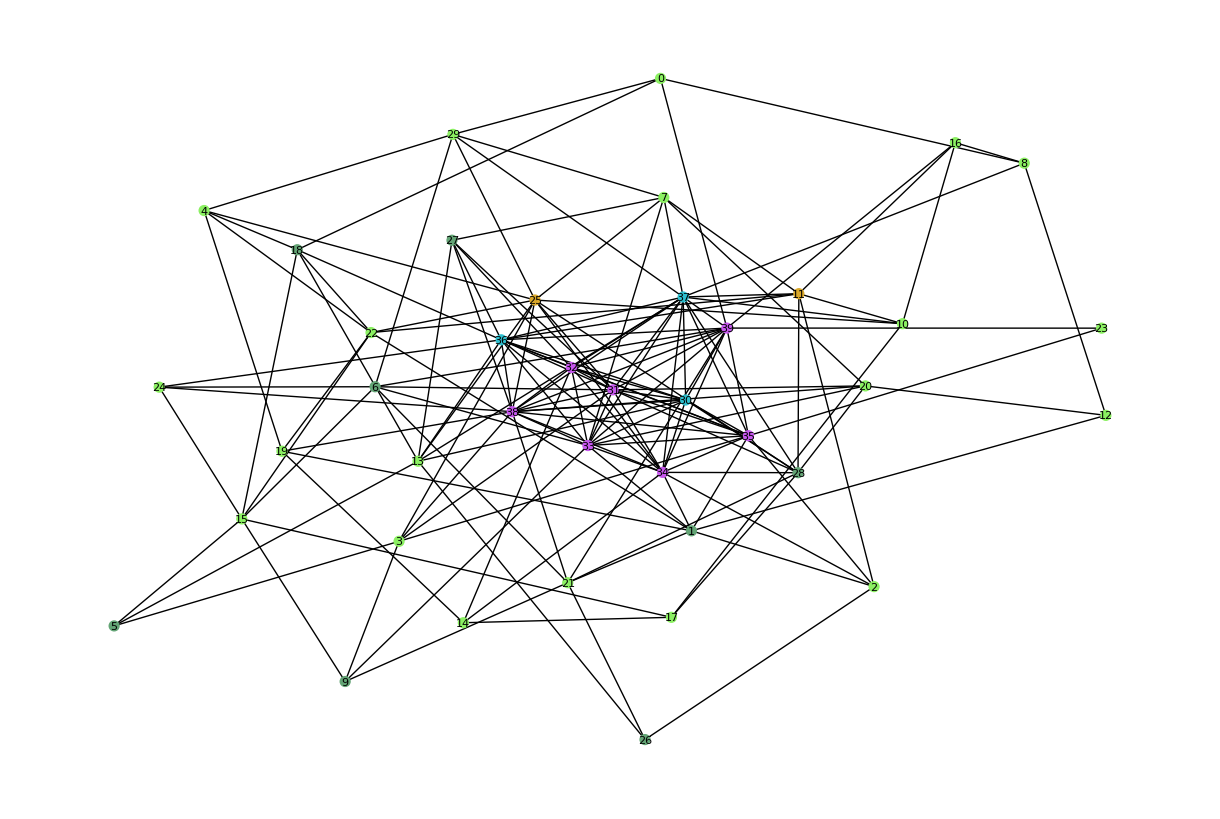

In [8]:
#Assuming G_normal and G_fraud are graphs constructed from your edgelist data
comparison_df = compare_graphs(G_normal, G_fraud)
high_activity_periods = find_activity_ranges(G_fraud)
cohort_sizes = find_cohorts(G_fraud)
visualize_network(G_fraud)

In [9]:
comparison_df

,node_count,edge_count,avg_degree,avg_clustering_coefficient,connected_components
Normal,100,200,4.00,0.029262,4
Fraud,40,153,7.65,0.287532,1


In [10]:
high_activity_periods

[(datetime.datetime(2021, 1, 3, 18, 0), 1),
 (datetime.datetime(2021, 1, 2, 21, 0), 1),
 (datetime.datetime(2021, 1, 1, 9, 0), 1),
 (datetime.datetime(2021, 1, 4, 1, 0), 1),
 (datetime.datetime(2021, 1, 6, 17, 0), 1),
 (datetime.datetime(2021, 1, 5, 8, 0), 1),
 (datetime.datetime(2021, 1, 1, 20, 0), 1),
 (datetime.datetime(2021, 1, 1, 17, 0), 1),
 (datetime.datetime(2021, 1, 6, 5, 0), 1),
 (datetime.datetime(2021, 1, 5, 11, 0), 1),
 (datetime.datetime(2021, 1, 4, 12, 0), 1),
 (datetime.datetime(2021, 1, 2, 9, 0), 1),
 (datetime.datetime(2021, 1, 1, 7, 0), 1),
 (datetime.datetime(2021, 1, 3, 20, 0), 1),
 (datetime.datetime(2021, 1, 2, 22, 0), 1),
 (datetime.datetime(2021, 1, 5, 12, 0), 1),
 (datetime.datetime(2021, 1, 1, 6, 0), 1),
 (datetime.datetime(2021, 1, 2, 6, 0), 1),
 (datetime.datetime(2021, 1, 5, 5, 0), 1),
 (datetime.datetime(2021, 1, 3, 7, 0), 1),
 (datetime.datetime(2021, 1, 2, 0, 0), 1),
 (datetime.datetime(2021, 1, 5, 9, 0), 1),
 (datetime.datetime(2021, 1, 4, 0, 0), 1),
 

In [11]:
cohort_sizes

Counter({1: 20, 4: 8, 0: 7, 3: 3, 2: 2})

In [18]:
import pandas as pd
import networkx as nx
from datetime import datetime

def preprocess_timestamps(edgelist):
    """
    Convert edgelist timestamps to pandas DataFrame with aggregated counts over time intervals.
    Assumes timestamps in edgelist are in a format that pandas can parse directly.
    """
    # Convert edgelist to DataFrame if it's not already
    if not isinstance(edgelist, pd.DataFrame):
        edgelist = pd.DataFrame(edgelist)
    
    # Ensure timestamps are in datetime format
    edgelist['edge_timestamp'] = pd.to_datetime(edgelist['edge_timestamp'])
    
    # Resample to aggregate counts by an interval (e.g., 'H' for hourly)
    time_series = edgelist.resample('H', on='edge_timestamp').size()
    return time_series

from statsmodels.tsa.arima.model import ARIMA

def detect_anomalies(time_series):
    """
    Detect anomalies in a time series using ARIMA model.
    """
    model = ARIMA(time_series, order=(5,1,0))
    model_fit = model.fit()
    
    # Forecasting the next values
    forecast = model_fit.forecast(steps=5)
    
    # This part is simplistic; in practice, you'd compare forecasted values with actual values
    # and apply statistical tests to identify significant deviations as anomalies.
    return forecast

def compare_time_series(ts1, ts2):
    """
    Compare two time series to identify differences. This function plots both time series for visual comparison.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(ts1, label='Sample 1')
    plt.plot(ts2, label='Sample 2', alpha=0.7)
    plt.legend()
    plt.show()


import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_edgelist(num_nodes=100, num_edges=200, start_date="2021-01-01", end_date="2021-01-31", fraud_scenario=False):
    """
    Generate an edgelist DataFrame with specified properties.

    Parameters:
    - num_nodes: Number of unique nodes to include.
    - num_edges: Total number of edges (interactions) to generate.
    - start_date & end_date: Date range for generating timestamps of interactions.
    - fraud_scenario: If True, generates a skewed distribution of interactions to simulate fraud.
    
    Returns:
    - A pandas DataFrame representing the edgelist.
    """
    # Generate node IDs
    node_ids = np.arange(1, num_nodes + 1)
    
    # Create edges
    edges = []
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    for _ in range(num_edges):
        if fraud_scenario:
            # For fraud scenarios, skew the node selection towards a smaller subset
            node1 = np.random.choice(node_ids[:num_nodes // 10])
            node2 = np.random.choice(node_ids[:num_nodes // 10])
        else:
            node1 = np.random.choice(node_ids)
            node2 = np.random.choice(node_ids)
        
        # Avoid self-loops
        while node1 == node2:
            node2 = np.random.choice(node_ids)
        
        # Randomly generate timestamps within the specified range
        timestamp = start_date + timedelta(seconds=np.random.randint(0, int((end_date - start_date).total_seconds())))
        
        # Simulate different types of interactions/events
        event_types = ['login', 'transaction', 'logout', 'account_creation']
        business_event_type = np.random.choice(event_types)
        
        edges.append({
            'node1_id': node1,
            'node2_id': node2,
            'node1_type': 'User',
            'node2_type': 'User' if np.random.rand() > 0.5 else 'Service',
            'business_event_id': np.random.randint(1, 1000),
            'business_event_type': business_event_type,
            'edge_timestamp': timestamp
        })

    return pd.DataFrame(edges)



In [19]:
# Example usage:
# Generate a normal operation edgelist
edgelist_normal = generate_edgelist(num_nodes=100, num_edges=200, fraud_scenario=False)

# Generate an edgelist simulating a fraud scenario
edgelist_fraud = generate_edgelist(num_nodes=100, num_edges=200, fraud_scenario=True)

# You can adjust the parameters to simulate different scenarios and properties

C:\Users\nyihm\AppData\Local\Temp\ipykernel_150264\433386592.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = edgelist.resample('H', on='edge_timestamp').size()
C:\Users\nyihm\AppData\Local\Temp\ipykernel_150264\433386592.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = edgelist.resample('H', on='edge_timestamp').size()


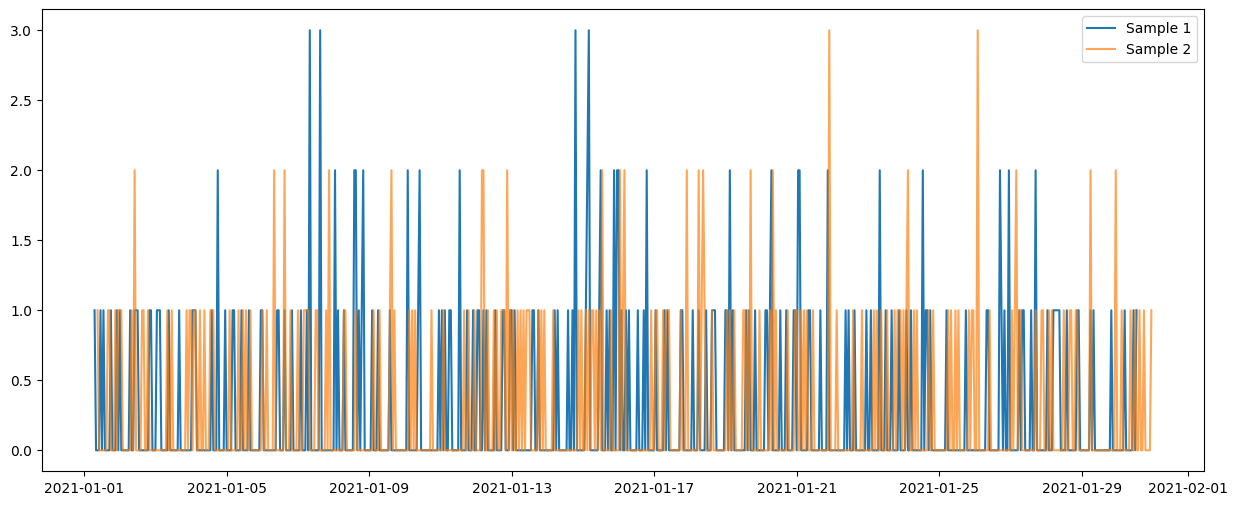

In [20]:
# Assuming you have two edgelists: edgelist_normal and edgelist_fraud
time_series_normal = preprocess_timestamps(edgelist_normal)
time_series_fraud = preprocess_timestamps(edgelist_fraud)

# Optionally, detect anomalies in each
anomalies_normal = detect_anomalies(time_series_normal)
anomalies_fraud = detect_anomalies(time_series_fraud)

# Compare the two time series visually
compare_time_series(time_series_normal, time_series_fraud)


In [21]:
anomalies_normal

2021-01-30 14:00:00    0.336438
2021-01-30 15:00:00    0.357229
2021-01-30 16:00:00    0.443184
2021-01-30 17:00:00    0.496314
2021-01-30 18:00:00    0.446813
Freq: h, Name: predicted_mean, dtype: float64

In [22]:
anomalies_fraud

2021-01-31 00:00:00    0.272612
2021-01-31 01:00:00    0.259654
2021-01-31 02:00:00    0.276006
2021-01-31 03:00:00    0.324482
2021-01-31 04:00:00    0.337643
Freq: h, Name: predicted_mean, dtype: float64

In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

# Assuming `timestamps` is a sorted list of timestamps from find_activity_ranges function
def analyze_time_series(timestamps):
    # Convert timestamps to a Pandas Series (you might need to aggregate/count by time intervals)
    ts = pd.Series(timestamps).value_counts().sort_index()
    
    # Fit an ARIMA model
    model = ARIMA(ts, order=(5,1,0))
    model_fit = model.fit()
    
    # Forecast the next N periods
    
    forecast = model_fit.forecast(steps=10)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(ts.index, ts, label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.legend()
    plt.show()

c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nyihm\AppData\Local\Programs\Py

ConversionError: Failed to convert value(s) to axis units: array([(datetime.datetime(2021, 1, 1, 0, 0), 1),
       (datetime.datetime(2021, 1, 1, 1, 0), 1),
       (datetime.datetime(2021, 1, 1, 2, 0), 1),
       (datetime.datetime(2021, 1, 1, 3, 0), 1),
       (datetime.datetime(2021, 1, 1, 4, 0), 1),
       (datetime.datetime(2021, 1, 1, 5, 0), 1),
       (datetime.datetime(2021, 1, 1, 6, 0), 1),
       (datetime.datetime(2021, 1, 1, 7, 0), 1),
       (datetime.datetime(2021, 1, 1, 8, 0), 1),
       (datetime.datetime(2021, 1, 1, 9, 0), 1),
       (datetime.datetime(2021, 1, 1, 10, 0), 1),
       (datetime.datetime(2021, 1, 1, 11, 0), 1),
       (datetime.datetime(2021, 1, 1, 12, 0), 1),
       (datetime.datetime(2021, 1, 1, 13, 0), 1),
       (datetime.datetime(2021, 1, 1, 14, 0), 1),
       (datetime.datetime(2021, 1, 1, 15, 0), 1),
       (datetime.datetime(2021, 1, 1, 16, 0), 1),
       (datetime.datetime(2021, 1, 1, 17, 0), 1),
       (datetime.datetime(2021, 1, 1, 18, 0), 1),
       (datetime.datetime(2021, 1, 1, 19, 0), 1),
       (datetime.datetime(2021, 1, 1, 20, 0), 1),
       (datetime.datetime(2021, 1, 1, 21, 0), 1),
       (datetime.datetime(2021, 1, 1, 22, 0), 1),
       (datetime.datetime(2021, 1, 1, 23, 0), 1),
       (datetime.datetime(2021, 1, 2, 0, 0), 1),
       (datetime.datetime(2021, 1, 2, 1, 0), 1),
       (datetime.datetime(2021, 1, 2, 2, 0), 1),
       (datetime.datetime(2021, 1, 2, 3, 0), 1),
       (datetime.datetime(2021, 1, 2, 4, 0), 1),
       (datetime.datetime(2021, 1, 2, 5, 0), 1),
       (datetime.datetime(2021, 1, 2, 6, 0), 1),
       (datetime.datetime(2021, 1, 2, 7, 0), 1),
       (datetime.datetime(2021, 1, 2, 8, 0), 1),
       (datetime.datetime(2021, 1, 2, 9, 0), 1),
       (datetime.datetime(2021, 1, 2, 10, 0), 1),
       (datetime.datetime(2021, 1, 2, 11, 0), 1),
       (datetime.datetime(2021, 1, 2, 12, 0), 1),
       (datetime.datetime(2021, 1, 2, 13, 0), 1),
       (datetime.datetime(2021, 1, 2, 14, 0), 1),
       (datetime.datetime(2021, 1, 2, 15, 0), 1),
       (datetime.datetime(2021, 1, 2, 16, 0), 1),
       (datetime.datetime(2021, 1, 2, 17, 0), 1),
       (datetime.datetime(2021, 1, 2, 18, 0), 1),
       (datetime.datetime(2021, 1, 2, 19, 0), 1),
       (datetime.datetime(2021, 1, 2, 20, 0), 1),
       (datetime.datetime(2021, 1, 2, 21, 0), 1),
       (datetime.datetime(2021, 1, 2, 22, 0), 1),
       (datetime.datetime(2021, 1, 2, 23, 0), 1),
       (datetime.datetime(2021, 1, 3, 0, 0), 1),
       (datetime.datetime(2021, 1, 3, 1, 0), 1),
       (datetime.datetime(2021, 1, 3, 2, 0), 1),
       (datetime.datetime(2021, 1, 3, 3, 0), 1),
       (datetime.datetime(2021, 1, 3, 4, 0), 1),
       (datetime.datetime(2021, 1, 3, 5, 0), 1),
       (datetime.datetime(2021, 1, 3, 6, 0), 1),
       (datetime.datetime(2021, 1, 3, 7, 0), 1),
       (datetime.datetime(2021, 1, 3, 8, 0), 1),
       (datetime.datetime(2021, 1, 3, 9, 0), 1),
       (datetime.datetime(2021, 1, 3, 10, 0), 1),
       (datetime.datetime(2021, 1, 3, 11, 0), 1),
       (datetime.datetime(2021, 1, 3, 12, 0), 1),
       (datetime.datetime(2021, 1, 3, 13, 0), 1),
       (datetime.datetime(2021, 1, 3, 14, 0), 1),
       (datetime.datetime(2021, 1, 3, 15, 0), 1),
       (datetime.datetime(2021, 1, 3, 16, 0), 1),
       (datetime.datetime(2021, 1, 3, 17, 0), 1),
       (datetime.datetime(2021, 1, 3, 18, 0), 1),
       (datetime.datetime(2021, 1, 3, 19, 0), 1),
       (datetime.datetime(2021, 1, 3, 20, 0), 1),
       (datetime.datetime(2021, 1, 3, 21, 0), 1),
       (datetime.datetime(2021, 1, 3, 22, 0), 1),
       (datetime.datetime(2021, 1, 3, 23, 0), 1),
       (datetime.datetime(2021, 1, 4, 0, 0), 1),
       (datetime.datetime(2021, 1, 4, 1, 0), 1),
       (datetime.datetime(2021, 1, 4, 2, 0), 1),
       (datetime.datetime(2021, 1, 4, 3, 0), 1),
       (datetime.datetime(2021, 1, 4, 4, 0), 1),
       (datetime.datetime(2021, 1, 4, 5, 0), 1),
       (datetime.datetime(2021, 1, 4, 6, 0), 1),
       (datetime.datetime(2021, 1, 4, 7, 0), 1),
       (datetime.datetime(2021, 1, 4, 8, 0), 1),
       (datetime.datetime(2021, 1, 4, 9, 0), 1),
       (datetime.datetime(2021, 1, 4, 10, 0), 1),
       (datetime.datetime(2021, 1, 4, 11, 0), 1),
       (datetime.datetime(2021, 1, 4, 12, 0), 1),
       (datetime.datetime(2021, 1, 4, 13, 0), 1),
       (datetime.datetime(2021, 1, 4, 14, 0), 1),
       (datetime.datetime(2021, 1, 4, 15, 0), 1),
       (datetime.datetime(2021, 1, 4, 16, 0), 1),
       (datetime.datetime(2021, 1, 4, 17, 0), 1),
       (datetime.datetime(2021, 1, 4, 18, 0), 1),
       (datetime.datetime(2021, 1, 4, 19, 0), 1),
       (datetime.datetime(2021, 1, 4, 20, 0), 1),
       (datetime.datetime(2021, 1, 4, 21, 0), 1),
       (datetime.datetime(2021, 1, 4, 22, 0), 1),
       (datetime.datetime(2021, 1, 4, 23, 0), 1),
       (datetime.datetime(2021, 1, 5, 0, 0), 1),
       (datetime.datetime(2021, 1, 5, 1, 0), 1),
       (datetime.datetime(2021, 1, 5, 2, 0), 1),
       (datetime.datetime(2021, 1, 5, 3, 0), 1),
       (datetime.datetime(2021, 1, 5, 4, 0), 1),
       (datetime.datetime(2021, 1, 5, 5, 0), 1),
       (datetime.datetime(2021, 1, 5, 6, 0), 1),
       (datetime.datetime(2021, 1, 5, 7, 0), 1),
       (datetime.datetime(2021, 1, 5, 8, 0), 1),
       (datetime.datetime(2021, 1, 5, 9, 0), 1),
       (datetime.datetime(2021, 1, 5, 10, 0), 1),
       (datetime.datetime(2021, 1, 5, 11, 0), 1),
       (datetime.datetime(2021, 1, 5, 12, 0), 1),
       (datetime.datetime(2021, 1, 5, 13, 0), 1),
       (datetime.datetime(2021, 1, 5, 14, 0), 1),
       (datetime.datetime(2021, 1, 5, 15, 0), 1),
       (datetime.datetime(2021, 1, 5, 16, 0), 1),
       (datetime.datetime(2021, 1, 5, 17, 0), 1),
       (datetime.datetime(2021, 1, 5, 18, 0), 1),
       (datetime.datetime(2021, 1, 5, 19, 0), 1),
       (datetime.datetime(2021, 1, 5, 20, 0), 1),
       (datetime.datetime(2021, 1, 5, 21, 0), 1),
       (datetime.datetime(2021, 1, 5, 22, 0), 1),
       (datetime.datetime(2021, 1, 5, 23, 0), 1),
       (datetime.datetime(2021, 1, 6, 0, 0), 1),
       (datetime.datetime(2021, 1, 6, 1, 0), 1),
       (datetime.datetime(2021, 1, 6, 2, 0), 1),
       (datetime.datetime(2021, 1, 6, 3, 0), 1),
       (datetime.datetime(2021, 1, 6, 4, 0), 1),
       (datetime.datetime(2021, 1, 6, 5, 0), 1),
       (datetime.datetime(2021, 1, 6, 6, 0), 1),
       (datetime.datetime(2021, 1, 6, 7, 0), 1),
       (datetime.datetime(2021, 1, 6, 8, 0), 1),
       (datetime.datetime(2021, 1, 6, 9, 0), 1),
       (datetime.datetime(2021, 1, 6, 10, 0), 1),
       (datetime.datetime(2021, 1, 6, 11, 0), 1),
       (datetime.datetime(2021, 1, 6, 12, 0), 1),
       (datetime.datetime(2021, 1, 6, 13, 0), 1),
       (datetime.datetime(2021, 1, 6, 14, 0), 1),
       (datetime.datetime(2021, 1, 6, 15, 0), 1),
       (datetime.datetime(2021, 1, 6, 16, 0), 1),
       (datetime.datetime(2021, 1, 6, 17, 0), 1),
       (datetime.datetime(2021, 1, 6, 18, 0), 1),
       (datetime.datetime(2021, 1, 6, 19, 0), 1),
       (datetime.datetime(2021, 1, 6, 20, 0), 1),
       (datetime.datetime(2021, 1, 6, 21, 0), 1),
       (datetime.datetime(2021, 1, 6, 22, 0), 1),
       (datetime.datetime(2021, 1, 6, 23, 0), 1),
       (datetime.datetime(2021, 1, 7, 0, 0), 1),
       (datetime.datetime(2021, 1, 7, 1, 0), 1),
       (datetime.datetime(2021, 1, 7, 2, 0), 1),
       (datetime.datetime(2021, 1, 7, 3, 0), 1),
       (datetime.datetime(2021, 1, 7, 4, 0), 1),
       (datetime.datetime(2021, 1, 7, 5, 0), 1),
       (datetime.datetime(2021, 1, 7, 6, 0), 1),
       (datetime.datetime(2021, 1, 7, 7, 0), 1),
       (datetime.datetime(2021, 1, 7, 8, 0), 1)], dtype=object)

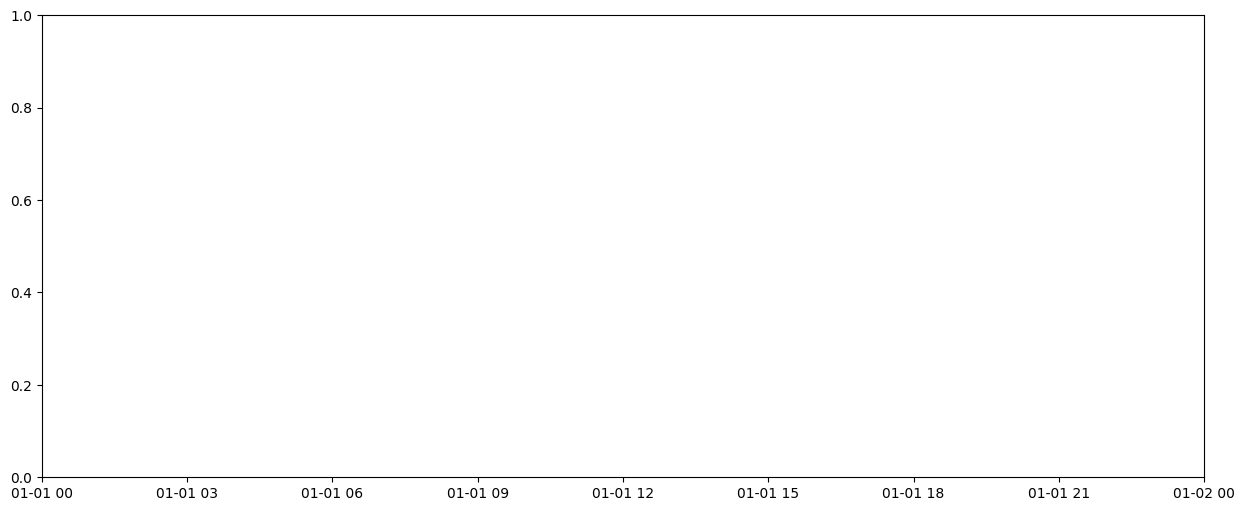

In [14]:
# Example usage
analyze_time_series(high_activity_periods)

Loading BokehJS ...

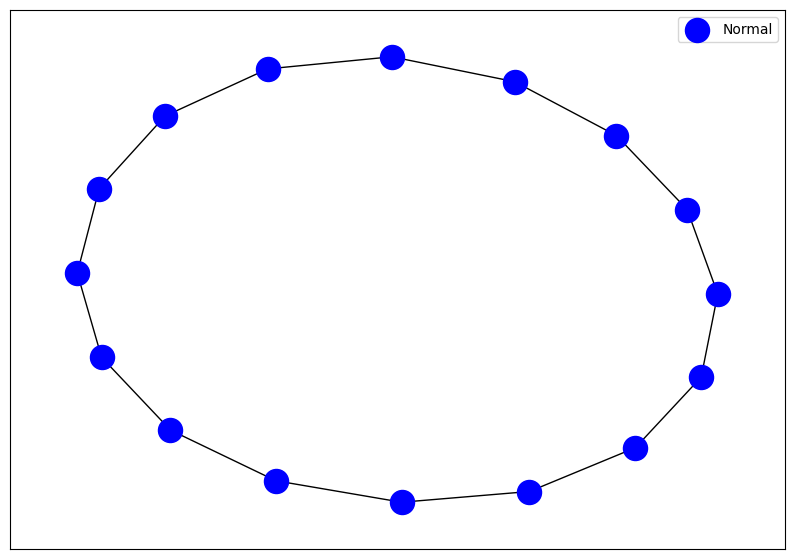

In [12]:
import pandas as pd
import networkx as nx
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, from_networkx
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

# Step 3: Feature Extraction
def extract_features(G):
    """
    Extract features from the graph for anomaly detection.
    Features could include node degree, clustering coefficient, etc.
    """
    features = pd.DataFrame(index=G.nodes())
    features['degree'] = pd.Series(dict(G.degree()))
    features['clustering'] = pd.Series(nx.clustering(G))
    # Additional features can be added here
    return features

# Step 4: Anomaly Detection
def detect_anomalies(features):
    """
    Detect anomalies in the graph using Isolation Forest.
    """
    model = IsolationForest(contamination=0.05)  # assuming 5% of the data might be outliers
    features['anomaly'] = model.fit_predict(features)
    anomalies = features[features['anomaly'] == -1]
    return anomalies

# Step 5: Visualization
def visualize_with_anomalies(G, anomalies):
    """
    Visualize the network with anomalies highlighted.
    """
    pos = nx.spring_layout(G)
    normal_nodes = [node for node in G.nodes() if node not in anomalies.index]
    anomaly_nodes = anomalies.index.tolist()
    
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_color='blue', label='Normal')
    nx.draw_networkx_nodes(G, pos, nodelist=anomaly_nodes, node_color='red', label='Anomaly')
    nx.draw_networkx_edges(G, pos)
    plt.legend()
    plt.show()

# Integration Example
# Assuming the edgelist CSV file is located at 'path/to/your/edgelist.csv'
#edgelist = load_and_preprocess_data('path/to/your/edgelist.csv')
G = construct_combined_graph(edgelist)  # Function from previous step
features = extract_features(G)
anomalies = detect_anomalies(features)
visualize_with_anomalies(G, anomalies)

Above was with Grimoire ChatGPT, Below is standard ChatGPT 4

In [29]:
import networkx as nx
import pandas as pd
from bokeh.plotting import figure, from_networkx
from bokeh.io import output_notebook, show
output_notebook()

def create_event_graph(edgelist):
    """
    Create a graph where nodes are business events, connected if they share a common node.
    
    Args:
        edgelist (pd.DataFrame): The edgelist dataframe.
    
    Returns:
        nx.Graph: A NetworkX graph object.
    """
    G = nx.Graph()
    for _, row in edgelist.iterrows():
        event_id = row['business_event_id']
        if event_id not in G:
            G.add_node(event_id, node_ids=set(), timestamps=[])
        G.nodes[event_id]['node_ids'].update([row['node1_id'], row['node2_id']])
        G.nodes[event_id]['timestamps'].append(row['edge_timestamp'])
        
        # Add edges if events share a node
        for other_event, data in G.nodes(data=True):
            if event_id != other_event and not set([row['node1_id'], row['node2_id']]).isdisjoint(data['node_ids']):
                G.add_edge(event_id, other_event)
    
    return G

def create_node_graph(edgelist):
    """
    Create a graph where nodes are node_ids and edges are business events.
    
    Args:
        edgelist (pd.DataFrame): The edgelist dataframe.
    
    Returns:
        nx.Graph: A NetworkX graph object.
    """
    G = nx.Graph()
    for _, row in edgelist.iterrows():
        G.add_edge(row['node1_id'], row['node2_id'], business_event_id=row['business_event_id'], timestamp=row['edge_timestamp'])
    return G

def create_mixed_graph(edgelist):
    """
    Create a graph where both business_event_ids and node_ids are nodes.
    
    Args:
        edgelist (pd.DataFrame): The edgelist dataframe.
    
    Returns:
        nx.Graph: A NetworkX graph object.
    """
    G = nx.Graph()
    for _, row in edgelist.iterrows():
        G.add_node(row['business_event_id'], type='business_event')
        G.add_node(row['node1_id'], type='node_id')
        G.add_node(row['node2_id'], type='node_id')
        
        G.add_edge(row['business_event_id'], row['node1_id'], timestamp=row['edge_timestamp'])
        G.add_edge(row['business_event_id'], row['node2_id'], timestamp=row['edge_timestamp'])
    return G

def analyze_network(G):
    """
    Analyze given network G for basic statistics.
    
    Args:
        G (nx.Graph): The NetworkX graph object.
        
    Returns:
        dict: A dictionary of network statistics.
    """
    stats = {
        'number_of_nodes': nx.number_of_nodes(G),
        'number_of_edges': nx.number_of_edges(G),
        'average_clustering': nx.average_clustering(G),
        'connected_components': nx.number_connected_components(G),
    }
    return stats

def compare_networks(G1, G2):
    """
    Compare two networks across all useful measures.
    
    Args:
        G1, G2 (nx.Graph): The NetworkX graph objects.
        
    Returns:
        dict: Differences in network statistics.
    """
    stats1 = analyze_network(G1)
    stats2 = analyze_network(G2)
    
    differences = {key: stats2[key] - stats1.get(key, 0) for key in stats2}
    return differences

def visualize_network(G):
    """
    Visualize a network using Bokeh. Suitable for smaller graphs.
    
    Args:
        G (nx.Graph): The NetworkX graph object to visualize.
    """
    plot = figure(title="Network Visualization", x_range=(-1.1, 1.1), y_range=(-1.1, 1.1),
                  tools="", toolbar_location=None)
    
    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))
    plot.renderers.append(graph_renderer)
    
    show(plot)


Loading BokehJS ...

In [30]:
G_event = create_event_graph(edgelist)
G_node = create_node_graph(edgelist)
G_mixed = create_mixed_graph(edgelist)
# Now G_event, G_node, and G_mixed can be analyzed or compared as needed.


In [31]:
visualize_network(G_event)
visualize_network(G_node)
visualize_network(G_mixed)

In [32]:
compare_networks(G_fraud, G_normal)

{'number_of_nodes': 60,
 'number_of_edges': 47,
 'average_clustering': -0.25827007714507716,
 'connected_components': 3}